In [15]:
import importlib_resources
import numpy as np
import csv



In [16]:
# Specify the file path
file_path = 'Data/2015.csv'
doc = []
# Open the CSV file
with open(file_path, 'r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Each row is a list representing the columns in that row
        doc.append(row)
doc



[['Country',
  'Region',
  'Happiness Rank',
  'Happiness Score',
  'Standard Error',
  'Economy (GDP per Capita)',
  'Family',
  'Health (Life Expectancy)',
  'Freedom',
  'Trust (Government Corruption)',
  'Generosity',
  'Dystopia Residual'],
 ['Switzerland',
  'Western Europe',
  '1',
  '7.587',
  '0.03411',
  '1.39651',
  '1.34951',
  '0.94143',
  '0.66557',
  '0.41978',
  '0.29678',
  '2.51738'],
 ['Iceland',
  'Western Europe',
  '2',
  '7.561',
  '0.04884',
  '1.30232',
  '1.40223',
  '0.94784',
  '0.62877',
  '0.14145',
  '0.4363',
  '2.70201'],
 ['Denmark',
  'Western Europe',
  '3',
  '7.527',
  '0.03328',
  '1.32548',
  '1.36058',
  '0.87464',
  '0.64938',
  '0.48357',
  '0.34139',
  '2.49204'],
 ['Norway',
  'Western Europe',
  '4',
  '7.522',
  '0.0388',
  '1.459',
  '1.33095',
  '0.88521',
  '0.66973',
  '0.36503',
  '0.34699',
  '2.46531'],
 ['Canada',
  'North America',
  '5',
  '7.427',
  '0.03553',
  '1.32629',
  '1.32261',
  '0.90563',
  '0.63297',
  '0.32957',
  '0

In [61]:
# Extract attribute names (1st row, column 4 to 12)
attributeNames = doc[0][0:12]

# Extract class names to python list,
# then encode with integers (dict)

classLabels = [row[1] for row in doc[1:]]  # The class labels are in the first column
classNames = list(set(classLabels))
classNames = sorted(classNames, key=str.lower) # Sort the class names
classDict = dict(zip(classNames,range(len(classNames))))

print(classDict)

# Extract vector y containing the name labels and class names of classDict, convert to NumPy array
y = np.asarray([classDict[value] for value in classLabels])

# Preallocate memory, then extract excel data to matrix X
X = np.empty((len(doc[1:]), len(doc[0][2:])))

# Extract data to X
for i, row in enumerate(doc[1:]):
    X[i, :] = [float(num) for num in row[2:]]


# Compute values of N, M and C.
N = len(y)
M = len(attributeNames)
C = len(classNames)








{'Australia and New Zealand': 0, 'Central and Eastern Europe': 1, 'Eastern Asia': 2, 'Latin America and Caribbean': 3, 'Middle East and Northern Africa': 4, 'North America': 5, 'Southeastern Asia': 6, 'Southern Asia': 7, 'Sub-Saharan Africa': 8, 'Western Europe': 9}
[9 9 9 9 5 9 9 9 0 0 4 3 9 3 5 3 9 9 9 4 9 4 3 6 3 9 3 4 9 3 1 3 3 6 4 9 9
 2 4 3 3 3 3 1 1 2 2 3 4 9 3 1 3 1 1 1 3 3 1 1 6 1 4 1 3 9 9 4 1 1 8 2 1 6
 6 4 1 8 7 1 7 4 1 2 8 1 1 9 1 6 8 4 1 8 1 1 8 3 6 2 8 9 4 1 3 1 4 4 7 4 1
 4 8 8 8 8 7 8 3 8 7 8 8 8 8 8 1 8 6 1 8 7 8 1 4 4 8 8 8 8 8 8 8 8 6 8 8 8
 8 8 8 8 7 8 8 4 8 8]
[[1.00000e+00 7.58700e+00 3.41100e-02 ... 4.19780e-01 2.96780e-01
  2.51738e+00]
 [2.00000e+00 7.56100e+00 4.88400e-02 ... 1.41450e-01 4.36300e-01
  2.70201e+00]
 [3.00000e+00 7.52700e+00 3.32800e-02 ... 4.83570e-01 3.41390e-01
  2.49204e+00]
 ...
 [1.56000e+02 3.00600e+00 5.01500e-02 ... 1.89060e-01 4.71790e-01
  3.28580e-01]
 [1.57000e+02 2.90500e+00 8.65800e-02 ... 1.00620e-01 1.97270e-01
  1.83302e+00]
 

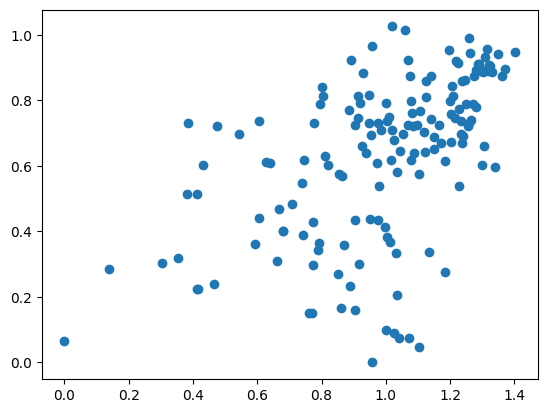

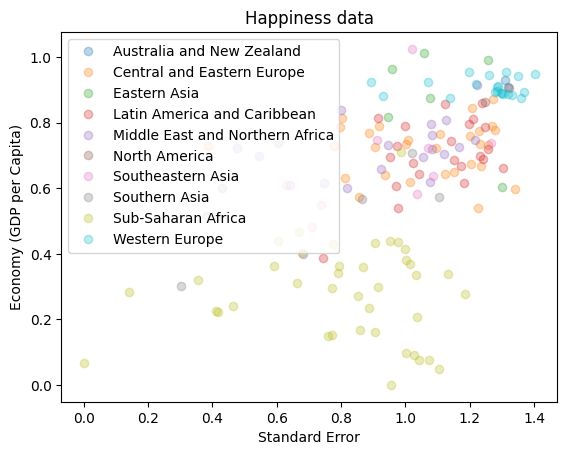

Ran Exercise 2.1.2


In [69]:

from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel

# Data attributes to be plotted
i = 4
j = 5

##
# Make a simple plot of the i'th attribute against the j'th attribute
# Notice that X is of matrix type (but it will also work with a numpy array)
# X = np.array(X) #Try to uncomment this line
plot(X[:, i], X[:, j], "o")

# %%
# Make another more fancy plot that includes legend, class labels,
# attribute names, and a title.
f = figure()
title("Happiness data")

for c in range(C):
    # select indices belonging to class c:
    class_mask = y == c
    plot(X[class_mask, i], X[class_mask, j], "o", alpha=0.3)

legend(classNames)
xlabel(attributeNames[i])
ylabel(attributeNames[j])

# Output result to screen
show()
print("Ran Exercise 2.1.2")








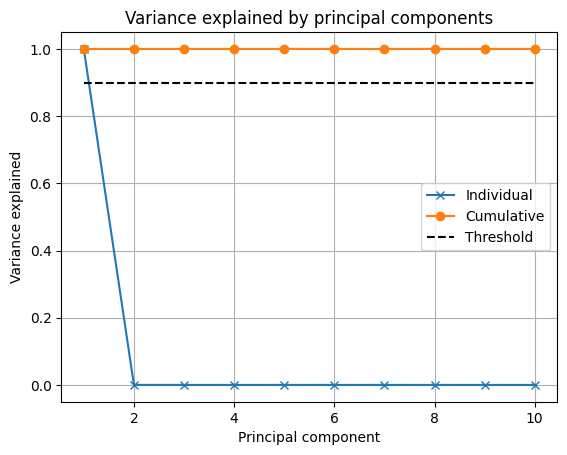

Ran Exercise 2.1.3


In [65]:

import matplotlib.pyplot as plt
from scipy.linalg import svd

# Subtract mean value from data
Y = X - np.ones((N, 1)) * X.mean(axis=0)

# PCA by computing SVD of Y
U, S, V = svd(Y, full_matrices=False)

# Compute variance explained by principal components
rho = (S * S) / (S * S).sum()

threshold = 0.9

# Plot variance explained
plt.figure()
plt.plot(range(1, len(rho) + 1), rho, "x-")
plt.plot(range(1, len(rho) + 1), np.cumsum(rho), "o-")
plt.plot([1, len(rho)], [threshold, threshold], "k--")
plt.title("Variance explained by principal components")
plt.xlabel("Principal component")
plt.ylabel("Variance explained")
plt.legend(["Individual", "Cumulative", "Threshold"])
plt.grid()
plt.show()

print("Ran Exercise 2.1.3")